Note: This code is run on Kaggle environment.

# Importing the required libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, AutoModelForSeq2SeqLM
from tqdm import tqdm
from torchvision import models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing import image
from torchmetrics.classification import MultilabelF1Score
from sklearn.metrics import average_precision_score, ndcg_score

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

### Setting up the environment
***

In [2]:
warnings.filterwarnings("ignore")

***

# Data Preprocessing

18 Genres from file genres.txt

In [3]:
genres = ["Crime", "Thriller", "Fantasy", "Horror", "Sci-Fi", "Comedy", "Documentary", "Adventure", "Film-Noir", "Animation", "Romance", "Drama", "Western", "Musical", "Action", "Mystery", "War", "Children\'s"]
mapping = {}
for i in range(len(genres)):
    mapping[i] = genres[i]
mapping

{0: 'Crime',
 1: 'Thriller',
 2: 'Fantasy',
 3: 'Horror',
 4: 'Sci-Fi',
 5: 'Comedy',
 6: 'Documentary',
 7: 'Adventure',
 8: 'Film-Noir',
 9: 'Animation',
 10: 'Romance',
 11: 'Drama',
 12: 'Western',
 13: 'Musical',
 14: 'Action',
 15: 'Mystery',
 16: 'War',
 17: "Children's"}

***

In [4]:
trainset = pd.read_csv('/kaggle/input/ml-dataset-2023s1/trainset.csv')
testset = pd.read_csv('/kaggle/input/ml-dataset-2023s1/testset.csv')
trainset.label = trainset.label.apply(lambda x: eval(x))
testset.label = testset.label.apply(lambda x: eval(x))
trainset.img_path = trainset.img_path.apply(lambda x: x.replace('\\', '/'))
testset.img_path = testset.img_path.apply(lambda x: x.replace('\\', '/'))

This is actually the dataset given by our lecturer. We decided to push this dataset privately on Kaggle to be able to run this code on Kaggle.
The Dataset has 3106 rows in trainset and 777 rows in testset.
However, since generating movie plots each run costs over 2 hours to finish, we had generated it and then saved it to 2 .csv files.

In [5]:
print(len(trainset), len(testset))

3106 777


In [6]:
tokenizer_gen = AutoTokenizer.from_pretrained("MBZUAI/LaMini-Flan-T5-248M")
model_gen = AutoModelForSeq2SeqLM.from_pretrained("MBZUAI/LaMini-Flan-T5-248M")

tokenizer_config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [7]:
def generate_plot(df: pd.DataFrame, model: AutoModelForSeq2SeqLM, tokenizer: AutoTokenizer, device) -> pd.DataFrame:
    quote = 'What is the story of the movie {}?'
    model_gen.to(device)
    model_gen.eval()

    for i in tqdm(range(len(df))):
        with torch.no_grad():
            input_ids = tokenizer(quote.format(df.title[i]), return_tensors='pt').input_ids.to(device)
            output = model.generate(input_ids, max_length=256, do_sample=True, temperature=0.09)
            df.loc[i, 'plot'] = tokenizer.decode(output[0], skip_special_tokens=True)
    return df

This is our unused function to generate movie plots. Below is how we used it to generate data.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# trainset = generate_plot(trainset, model_gen, tokenizer_gen, device)
# testset = generate_plot(testset, model_gen, tokenizer_gen, device)

# Model Implementation

### Sub-models
***

In [10]:
tokenizer1 = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model1 = DistilBertForSequenceClassification .from_pretrained("distilbert-base-uncased", problem_type="multi_label_classification", num_labels=18)
model1.config.id2label = mapping

tokenizer2 = AutoTokenizer.from_pretrained("dduy193/plot-classification")
model2 = AutoModelForSequenceClassification.from_pretrained("dduy193/plot-classification")
model2.config.id2label = mapping

model3 = models.resnet101(pretrained=False)
model3.fc = torch.nn.Linear(2048, len(genres))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
model2.to(device)
model3.to(device)
device

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

device(type='cuda')

### Deep Fusion Multimodal Model
***

In [11]:
class Multimodal(torch.nn.Module):
    def __init__(self, model1, model2, model3):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.fc1 = torch.nn.Linear(18, 18)
        self.fc2 = torch.nn.Linear(18, 18)
        self.fc3 = torch.nn.Linear(18, 18)

    def forward(self, 
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input):
        title_output = self.model1(title_input_ids, title_attention_mask)
        plot_output = self.model2(plot_input_ids, plot_attention_mask)
        image_output = self.model3(image_input)

        title_output = self.fc1(title_output.logits)
        plot_output = self.fc2(plot_output.logits)
        image_output = self.fc3(image_output)
        
        output = torch.add(title_output, plot_output)
        output = torch.add(output, image_output)
        return output

# Custom Datasets & Data Loaders

***
### Custom Dataset
***

In [12]:
class Poroset(torch.utils.data.Dataset):
    def __init__(self, df, 
                 tokenizer1, tokenizer2, 
                 max_len1=64, max_len2=256,
                 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        self.df = df
        self.tokenizer1 = tokenizer1
        self.tokenizer2 = tokenizer2
        self.max_len1 = max_len1
        self.max_len2 = max_len2
        self.device = device
        self.transform = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        title = row['title']
        # Truncate title if it is too long
        if len(title) > self.max_len1:
            title = title[:self.max_len1]

        plot = row['plot']
        # Truncate plot if it is too long
        if len(plot) > self.max_len2:
            plot = plot[:self.max_len2]

        label = row['label']
        title_encoding = self.tokenizer1(title, truncation=True, padding='max_length', max_length=self.max_len1, return_tensors='pt')
        plot_encoding = self.tokenizer2(plot, truncation=True, padding='max_length', max_length=self.max_len2, return_tensors='pt')
        
        image_path = '/kaggle/input/ml-dataset-2023s1/ml1m/' + row['img_path']
        if os.path.exists(image_path):
            image_input = image.load_img(image_path)
            image_input = self.transform(image_input)
        else:
            image_input = torch.zeros((3, 224, 224))
        
        return {
            'title': title,
            'plot': plot,
            'title_input_ids': title_encoding['input_ids'].squeeze(),
            'title_attention_mask': title_encoding['attention_mask'].squeeze(),
            'plot_input_ids': plot_encoding['input_ids'].squeeze(),
            'plot_attention_mask': plot_encoding['attention_mask'].squeeze(),
            'image_input': image_input,
            'label': torch.FloatTensor(label)
        }

In [13]:
trainset.head()

,title,img_path,label,plot
0,Washington Square (1997),ml1m/content/dataset/ml1m-images/1650.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",Washington Square is a 1997 American film abou...
1,"Net, The (1995)",ml1m/content/dataset/ml1m-images/185.jpg,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Net is a 1995 American film directed by James ...
2,Batman Returns (1992),ml1m/content/dataset/ml1m-images/1377.jpg,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",Batman returns to the Batman universe after a ...
3,"Boys from Brazil, The (1978)",ml1m/content/dataset/ml1m-images/3204.jpg,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","The movie Boys from Brazil, The (1978) is a ro..."
4,Dear Jesse (1997),ml1m/content/dataset/ml1m-images/1901.jpg,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Dear Jesse is a 1997 American drama film about...


In [14]:
trainset = Poroset(df=trainset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                   max_len1=64, max_len2=256,
                   device=device)
testset = Poroset(df=testset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                  max_len1=64, max_len2=256,
                  device=device)


***
### Custom Data Loader
***

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

Check if the data loader is working properly

Title:  Children of the Corn III (1994)
Plot:  The movie "Children of the Corn III" (1994) is about a young boy named Jack who is a sailor and a fisherman who is stranded on a deserted island. He is rescued by a group of fishermen who are trying to find him and rescue him.
Label:  tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


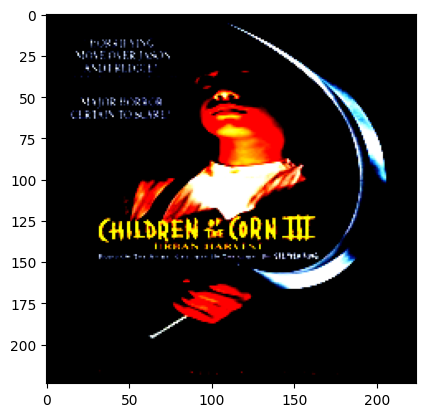

In [16]:
sample = next(iter(testloader))

# First sample of the batch
print('Title: ', sample['title'][3])
print('Plot: ', sample['plot'][3])
print('Label: ', sample['label'][3])
plt.imshow(sample['image_input'][3].permute(1, 2, 0))

# Setting up the Trainer

***
### GPU & Model Configuration
***

In [17]:
model = Multimodal(model1, model2, model3)
model.to(device)
device

# Freeze layers
# for param in model.model2.parameters():
#     param.requires_grad = False

device(type='cuda')

***
### Setting up loss function & optimizer
***

In [18]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5)

***
### Trainer & Validation
***

In [19]:
history_loss = []
history_f1 = []
history_mapk = []
history_ndcg = []
def train(epoch):
    model.train()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)

    actual = []
    predicted = []
    for _, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        title_input_ids = data['title_input_ids'].to(device)
        title_attention_mask = data['title_attention_mask'].to(device)
        plot_input_ids = data['plot_input_ids'].to(device)
        plot_attention_mask = data['plot_attention_mask'].to(device)
        image_input = data['image_input'].to(device)
        label = data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(
            title_input_ids, title_attention_mask,
            plot_input_ids, plot_attention_mask,
            image_input
        )
        
        loss = loss_fn(outputs, label)
        loss.backward()
        optimizer.step()

        f1.update(outputs.sigmoid(), label)
        
        probabilities = outputs.sigmoid().cpu().detach().numpy()

        actual.append(label.cpu().detach().numpy())
        predicted.append(probabilities)
    actual_flat = np.vstack(actual)
    predicted_flat = np.vstack(predicted)
    maps = average_precision_score(actual_flat, predicted_flat, average="samples")
    
    ndcg = ndcg_score(actual_flat, predicted_flat)
    
    print(f'Epoch: {epoch}, Train Loss: {loss.item()}, Train F1: {f1.compute().item()}, Train MAP: {maps}, Train NDCG: {ndcg}')
    history_loss.append(loss.item())
    history_f1.append(f1.compute().item())
    history_mapk.append(maps)
    history_ndcg.append(ndcg)

# Training Loop

In [20]:
for epoch in range(16):
    train(epoch)

100%|██████████| 98/98 [01:53<00:00,  1.16s/it]


Epoch: 0, Train Loss: 0.2604980766773224, Train F1: 0.1412104368209839, Train MAP: 0.5009175700170833, Train NDCG: 0.6407130546740236


100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


Epoch: 1, Train Loss: 0.14701153337955475, Train F1: 0.09471239894628525, Train MAP: 0.6386329269650214, Train NDCG: 0.7483783894197124


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch: 2, Train Loss: 0.1106482595205307, Train F1: 0.21269632875919342, Train MAP: 0.7242214790297368, Train NDCG: 0.8110983966105387


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch: 3, Train Loss: 0.08019614219665527, Train F1: 0.4034595489501953, Train MAP: 0.8227135659888679, Train NDCG: 0.881951669632758


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch: 4, Train Loss: 0.10751357674598694, Train F1: 0.5388647317886353, Train MAP: 0.8910779870639581, Train NDCG: 0.9296395797091079


100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


Epoch: 5, Train Loss: 0.03833933547139168, Train F1: 0.6491369009017944, Train MAP: 0.9325851658864376, Train NDCG: 0.9571298040476531


100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


Epoch: 6, Train Loss: 0.007258483208715916, Train F1: 0.7642349004745483, Train MAP: 0.9643119578068065, Train NDCG: 0.977951414700054


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch: 7, Train Loss: 0.11018259078264236, Train F1: 0.8283388614654541, Train MAP: 0.9795396693883495, Train NDCG: 0.9875275768866687


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch: 8, Train Loss: 0.06776639074087143, Train F1: 0.8822757601737976, Train MAP: 0.9885511656905733, Train NDCG: 0.9933993613848717


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch: 9, Train Loss: 0.042212847620248795, Train F1: 0.9065127968788147, Train MAP: 0.9920478089199918, Train NDCG: 0.9952726808979728


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch: 10, Train Loss: 0.003549717366695404, Train F1: 0.9325761795043945, Train MAP: 0.9941357357495478, Train NDCG: 0.9964811796156123


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch: 11, Train Loss: 0.0052366540767252445, Train F1: 0.9543657302856445, Train MAP: 0.9971657135702533, Train NDCG: 0.9984174474916241


100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


Epoch: 12, Train Loss: 0.002149149775505066, Train F1: 0.9623235464096069, Train MAP: 0.998189372336185, Train NDCG: 0.9989966146013325


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch: 13, Train Loss: 0.005435428116470575, Train F1: 0.9737388491630554, Train MAP: 0.9990420486717976, Train NDCG: 0.9994954470900846


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch: 14, Train Loss: 0.0027075856924057007, Train F1: 0.9833641052246094, Train MAP: 0.9991724159077668, Train NDCG: 0.9995094824151739


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch: 15, Train Loss: 0.002378197619691491, Train F1: 0.9826716184616089, Train MAP: 0.9993217428632755, Train NDCG: 0.9996160653714945


In [21]:
# Save model
torch.save(model.state_dict(), 'multimodel.pt')

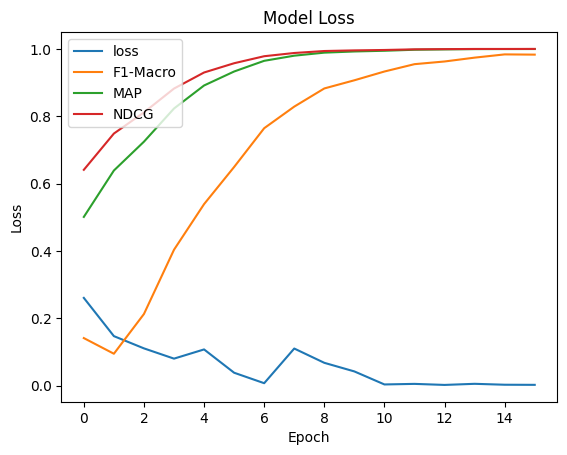

In [22]:
# Visualize
plt.plot(history_loss)
plt.plot(history_f1)
plt.plot(history_mapk)
plt.plot(history_ndcg)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'F1-Macro', 'MAP', 'NDCG'], loc='upper left')
plt.show()

# Testing the model

In [23]:
# Validation
def test(testing_loader):
    model.eval()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)

    actual = []
    predicted = []

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0), total=len(testing_loader)):
            title_input_ids = data['title_input_ids'].to(device)
            title_attention_mask = data['title_attention_mask'].to(device)
            plot_input_ids = data['plot_input_ids'].to(device)
            plot_attention_mask = data['plot_attention_mask'].to(device)
            image_input = data['image_input'].to(device)
            label = data['label'].to(device)

            outputs = model(
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input
            )
            f1.update(outputs.sigmoid(), label)
        
        probabilities = outputs.sigmoid().cpu().detach().numpy()

        actual.append(label.cpu().detach().numpy())
        predicted.append(probabilities)
    actual_flat = np.vstack(actual)
    predicted_flat = np.vstack(predicted)
    mapp = average_precision_score(actual_flat, predicted_flat, average="samples")
    
    ndcg = ndcg_score(actual_flat, predicted_flat)
    
    print(f'Test F1: {f1.compute().item()}, Test MAP: {mapp}, Test NDCG: {ndcg}')

In [24]:
test(testloader)

100%|██████████| 25/25 [00:14<00:00,  1.77it/s]

Test F1: 0.701256513595581, Test MAP: 0.9259259259259258, Test NDCG: 0.9522935243283689


Let's try inferencing a sample from the batch that we already saw earlier.

In [25]:
def inference(title, plot, image_input, tokenizer1=tokenizer1, tokenizer2=tokenizer2, model=model, genres=genres, device=device):
    title_input = tokenizer1(title, return_tensors='pt', padding=True, truncation=True)
    title_input_ids = title_input['input_ids'].to(device)
    title_attention_mask = title_input['attention_mask'].to(device)

    plot_input = tokenizer2(plot, return_tensors='pt', padding=True, truncation=True)
    plot_input_ids = plot_input['input_ids'].to(device)
    plot_attention_mask = plot_input['attention_mask'].to(device)

    image_input = image_input.to(device)
    print(title)
    print(plot)
    plt.imshow(image_input.permute(1, 2, 0).cpu().detach().numpy())

    output = model(title_input_ids, title_attention_mask, plot_input_ids, plot_attention_mask, image_input.unsqueeze(0))
    output = torch.sigmoid(output)
    output = output.cpu().detach().numpy()
    output = np.where(output > 0.5, 1, 0)
    output = output.squeeze()
    output = np.where(output == 1)[0]
    output = [genres[i] for i in output]
    return output

Children of the Corn III (1994)
The movie "Children of the Corn III" (1994) is about a young boy named Jack who is a sailor and a fisherman who is stranded on a deserted island. He is rescued by a group of fishermen who are trying to find him and rescue him.


['Horror']

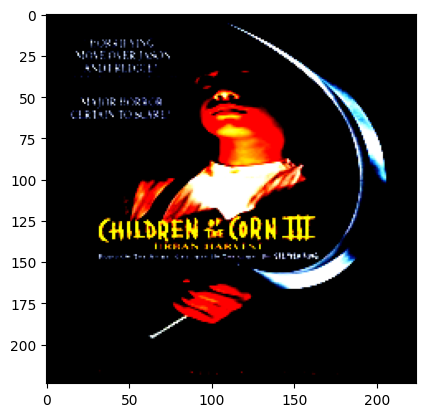

In [27]:
inference(sample['title'][3], sample['plot'][3], sample['image_input'][3])